In [52]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import shutil
from importlib import reload
import skimage.io
import scipy.io

from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csgraph

import matplotlib 
import matplotlib.pyplot as plt 

# local code
import sys
sys.path.append("../source/")

In [2]:
# DATA PATHS
ROOT_DIR = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/WH18/processed/control/"
EXPERIMENT = "control_1"
trackmate_path = f"{ROOT_DIR}{EXPERIMENT}.csv"
tiff_path = f"{ROOT_DIR}{EXPERIMENT}.tif"
OUTPUT_DIR = f"/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/PIP_FUCCI_ANALYSIS/WH18/processed/control/annotations/{EXPERIMENT}/"

# global vars
# SCALING = 1.4633
SCALING = 0.7310
MINUTES_PER_FRAME = 15

In [3]:
df = pd.read_csv(trackmate_path, skiprows=[1, 2, 3])

print(f"{df.shape=}")
df.head()

df.shape=(19437, 46)


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,ELLIPSE_X0,ELLIPSE_Y0,ELLIPSE_MAJOR,ELLIPSE_MINOR,ELLIPSE_THETA,ELLIPSE_ASPECTRATIO,AREA,PERIMETER,CIRCULARITY,SOLIDITY
0,ID2048,2048,0.0,0.871527,26.348699,293.307770,0.0,0.0,0,7.813571,...,-0.000851,0.006266,9.217907,6.702768,-0.560894,1.375239,191.800167,55.243380,0.789766,0.949074
1,ID2049,2049,1.0,0.870998,743.289277,578.797845,0.0,0.0,0,9.066239,...,0.033940,0.088550,11.032432,7.528647,-1.472172,1.465394,258.228518,61.117240,0.868734,0.975265
2,ID2050,2050,2.0,0.870230,81.720654,1243.879239,0.0,0.0,0,10.996023,...,0.003171,0.015591,11.406552,10.695609,0.783977,1.066471,379.857892,72.219114,0.915223,0.975962
3,ID2051,2051,3.0,0.870078,810.284137,170.812516,0.0,0.0,0,9.196695,...,0.046963,0.034582,11.691169,7.274885,1.042275,1.607059,265.713402,64.569181,0.800890,0.959459
4,ID2052,2052,4.0,0.869662,828.197972,384.969146,0.0,0.0,0,12.239301,...,-0.008978,-0.000175,13.735521,11.022353,1.185740,1.246151,470.612118,80.917051,0.903219,0.976699


In [20]:
min_track_length = 50

df['STEP'] =  df.groupby('TRACK_ID').transform('cumcount')
df['MAX_STEP'] =  df.groupby('TRACK_ID')['STEP'].transform('max')

####### perform all filtering on a temporary dataframe
tmp = df.copy()

filtered = df.groupby('TRACK_ID')['STEP'].max().reset_index()
filtered = filtered[filtered['STEP'] > min_track_length]
tmp = tmp[tmp['TRACK_ID'].isin(filtered['TRACK_ID'])]
print(f"{tmp['TRACK_ID'].nunique()=}")


df = tmp.copy()
df = df.sort_values(by=['TRACK_ID', 'FRAME'])

tmp['TRACK_ID'].nunique()=246


In [67]:

plt.rcParams['figure.dpi'] = 200

new_rows = []

radius = 100
pixel_radius = int(radius / SCALING)
print(f"{pixel_radius=} micron")

for frame in range(df['FRAME'].max()):
    
    points = df[df['FRAME'] == frame][['POSITION_X', 'POSITION_Y']]
    
    d = squareform(pdist(points))
    A = np.where(d < pixel_radius, 1, 0)
    A = A - np.eye(A.shape[0])
    L = csgraph.laplacian(A, normed=True)
    u, s, v = np.linalg.svd(L)

    row = {
        'time' : frame,
        'd' : d,
        'A' : A,
        'L' : L, 
        'ul' : u,
        'sl' : s,
    }
    
    new_rows.append(row)

    
res = pd.DataFrame(new_rows)
res.head()

pixel_radius=136 micron


,time,d,A,L,ul,sl
0,0,"[[0.0, 771.6918916458751, 952.1828447579788, 7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[[-7.959456455316629e-18, 2.882575060190276e-1...","[2.0000000000000004, 2.0000000000000004, 1.999..."
1,1,"[[0.0, 772.9802487460485, 951.4937185956641, 7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[[-7.524698682637274e-17, -1.2022383904901582e...","[2.0000000000000004, 2.0, 1.9999999999999991, ..."
2,2,"[[0.0, 771.1034938734894, 950.2271947844243, 7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[[-1.1523696424774798e-17, -8.734963645008626e...","[2.0000000000000013, 2.0, 1.8968663899312903, ..."
3,3,"[[0.0, 769.6861342574796, 947.5959511478687, 7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[[-4.842621264804257e-18, 2.1852628995331743e-...","[2.0, 1.9999999999999996, 1.8968669766234973, ..."
4,4,"[[0.0, 769.0022850185236, 945.2127544288061, 7...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0....","[[3.794523585124447e-17, 2.6625873811657175e-1...","[2.0, 1.9999999999999993, 1.813845483756772, 1..."


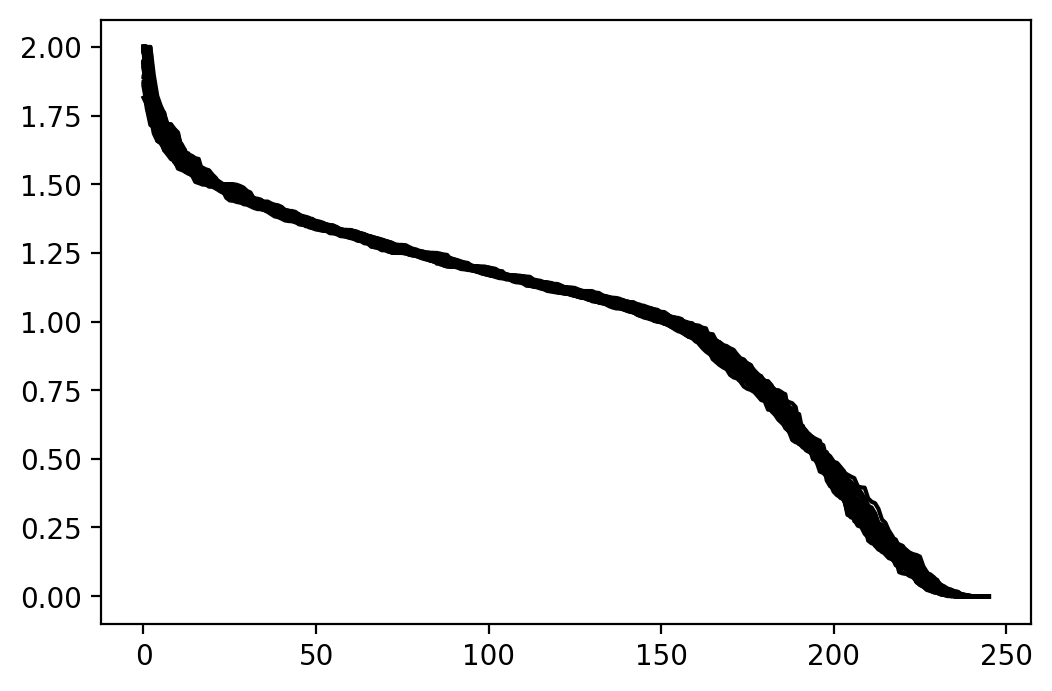

In [84]:


for t in range(res['time'].max()):
    tmp = res[res['time'] == t]
    
    s = tmp['sl'].values[0]
    
    plt.plot(s, '-k')
#     s = s[s != 0]s
    
#     fielder = sorted(s)[1]
    
    
#     plt.scatter(t, fielder)